# **PA4**
####Team:

  - Diego Ordonez Pasaje
  - Maria Rossano
  - Tanwi Sarkar


####Name of Data Set:
  - Polycystic ovary syndrome (PCOS) 

In [ ]:
# To do an analysis with shap first install shap:
!pip install shap

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import learning_curve
import plotly.graph_objects as go

#Import Shap:
import shap
shap.initjs()

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, plot_confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from sklearn import neighbors

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load Data**

In [ ]:
# Load Original Data
PCOS_path = "../Datasets/"

PCOS_file = PCOS_path + "PCOS_data_without_infertility.xlsx"
PCOS = pd.read_excel(PCOS_file, sheet_name="Full_new")

# **Balance of data**

In [ ]:
# This is a code for the pie chart:
df_group = PCOS['PCOS (Y/N)']
values = PCOS['PCOS (Y/N)'].value_counts()
names = ["No", "Yes"]
fig = px.pie(df_group, values=values, names=names, title='Proportion of PCOS')
fig.update_layout(title_font_size=32)
fig.update_traces(textfont_size=30, marker=dict(line=dict(width=2)))
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.95,
        xanchor="left",
        x=0.3),
    title=dict(
        y=0.98,
        x=0.3
        
    )
)
fig.show()

# **0. Data Transformation and Feature Engineering**

In [ ]:
# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 1. Drop non-features/labels columns and misaligned column**
# columns to be droped
columns_drop =['Sl. No', 'Patient File No.', \
                'Unnamed: 44']

# labels name
# JUST FOR DATA TRANSFORMATION, VARIABLE WILL BE REDIRECTED LATER:
labels_name ='PCOS (Y/N)' 

# 1. Drop columns in `not_to_be_used`
PCOS.drop(columns_drop, axis=1, inplace=True)

# Check
display(PCOS.head())
display(PCOS.tail())

# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 2. Address non float values**
### Feature 'AMH(ng/mL)' has a none float64 value in row: `305`
### Feature 'II    beta-HCG(mIU/mL)' has a none float64 value in row: `123`

# 2.  Address non float values in rows [305, 123].
# A. 
# Rest of values in PCOS.iloc[305] seem to be consistent w/neighbouring rows
#PCOS.iloc[[301, 302, 303, 304, 305]].T

# Thus, I suggest converting their value "a" into a nan
# and treat it as a missing value.
PCOS.replace(PCOS['AMH(ng/mL)'].iloc[305], np.nan, inplace=True)
PCOS['AMH(ng/mL)'] = pd.to_numeric(PCOS['AMH(ng/mL)'], errors = 'coerce')

# B.
# PCOS.iloc[[123, 124, 125]].T
# Seems to be an extra "." in the feature value "1.99.".
# Check with `PCOS['II    beta-HCG(mIU/mL)'].iloc[120:125].T`
PCOS.replace(PCOS['II    beta-HCG(mIU/mL)'].iloc[123], float(1.99), \
             inplace=True)
PCOS['II    beta-HCG(mIU/mL)'] = pd.to_numeric(PCOS['II    beta-HCG(mIU/mL)'],\
                                               errors='coerce')


# Check dtypes
PCOS.dtypes

# Check those specific feature values
print(f"\n305: {PCOS['AMH(ng/mL)'].iloc[305]}")
print(f"123: {PCOS['II    beta-HCG(mIU/mL)'].iloc[123]}\n")

# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 3. Drop outliers (i.e., rows with outliers)**

# 3. Drop outliers (i.e, rows with outliers):
rows_drop_dict = {"Pulse":[223, 296],
                  "BP_Systolic": [161], 
                  "BP_Diastolic": [200]}

drops = []
for val in rows_drop_dict.values():
  drops += val

PCOS.drop(drops, axis=0, inplace=True)


# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 4. Reindex**
# Reset index of df
PCOS.reset_index(drop=True, inplace=True)

,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,0.0,28.0,44.6,152.0,19.300000,15.0,78.0,22.0,10.48,2.0,...,0.0,1.0,0.0,110.0,80.0,3.0,3.0,18.0,18.0,8.5
1,0.0,36.0,65.0,161.5,24.921163,15.0,74.0,20.0,11.70,2.0,...,0.0,0.0,0.0,120.0,70.0,3.0,5.0,15.0,14.0,3.7
2,1.0,33.0,68.8,165.0,25.270891,11.0,72.0,18.0,11.80,2.0,...,1.0,1.0,0.0,120.0,80.0,13.0,15.0,18.0,20.0,10.0
3,0.0,37.0,65.0,148.0,29.674945,13.0,72.0,20.0,12.00,2.0,...,0.0,0.0,0.0,120.0,70.0,2.0,2.0,15.0,14.0,7.5
4,0.0,25.0,52.0,161.0,20.060954,11.0,72.0,18.0,10.00,2.0,...,0.0,0.0,0.0,120.0,80.0,3.0,4.0,16.0,14.0,7.0


,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
536,0.0,35.0,50.0,164.592,18.5,17.0,72.0,16.0,11.0,2.0,...,0.0,0.0,0.0,110.0,70.0,1.0,0.0,17.5,10.0,6.7
537,0.0,30.0,63.2,158.000,25.3,15.0,72.0,18.0,10.8,2.0,...,0.0,0.0,0.0,110.0,70.0,9.0,7.0,19.0,18.0,8.2
538,0.0,36.0,54.0,152.000,23.4,13.0,74.0,20.0,10.8,2.0,...,0.0,0.0,0.0,110.0,80.0,1.0,0.0,18.0,9.0,7.3
539,0.0,27.0,50.0,150.000,22.2,15.0,74.0,20.0,12.0,4.0,...,1.0,0.0,0.0,110.0,70.0,7.0,6.0,18.0,16.0,11.5
540,1.0,23.0,82.0,165.000,30.1,13.0,80.0,20.0,10.2,4.0,...,1.0,1.0,0.0,120.0,70.0,9.0,10.0,19.0,18.0,6.9



305: nan
123: 1.99



## **Feature Enconding**

In [ ]:
# Create feature labels of encoded features
features_categ_encode = ['Blood Group', 'Cycle(R/I)']
features_categ_rename = ['Blood_Group', 'Cycle(R/I)']
features_categ_rename = ["enc_" + feature.lower() for feature in features_categ_rename]


PCOS = pd.get_dummies(PCOS, columns=features_categ_encode, prefix=features_categ_rename)

## **Split Data**

In [ ]:
# Select data
pcos_clean_columns = PCOS.columns
X = PCOS[pcos_clean_columns[1:]]
y = PCOS[labels_name]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# y_train.head()

## **Feature transfomartion across rows and columns**

In [ ]:
X_data_list = [X_train, X_test]
# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 5. filling `Nan`'s values for specific rows**
# 305, 458, 156

# A. PCOS.iloc[[ 458]].T has a Nan value for the 'Marraige Status (Yrs)'
# This woman (PCOS.iloc[[ 458]]) has 36 year old
# So, we calculate the mean of 'Marraige Status (Yrs)' for those that only have 36 year old
# Then, we use this mean to fill the Nan value: 

# data points of women with 36 year all and their respective years of marriege:

for X_data in X_data_list:
  age36Marraige = X_data[X_data[' Age (yrs)']==36]['Marraige Status (Yrs)']
  age36Marraige_mean = age36Marraige.mean() 
  X_data['Marraige Status (Yrs)'].fillna(age36Marraige_mean, inplace=True)

  # B. PCOS.iloc[[ 156]].T has a Nan value for the 'Fast food (Y/N)'
  # We fill this value with the mode of 'Fast food (Y/N)':

  X_data['Fast food (Y/N)'].fillna(X_data['Fast food (Y/N)'].mode()[0], inplace=True)

  # C. PCOS.iloc[[ 305]].T has a Nan value for the feature "AMH(ng/mL)"
  mean_amh = X_data["AMH(ng/mL)"].mean()
  X_data["AMH(ng/mL)"].fillna(mean_amh, inplace=True)



  # ----------------------------------------------------------
  # ----------------------------------------------------------
  ## **STEP 6. Recalculate BMI and drop `BMI` column**
  # Recalculate BMI
  def get_bmi(row):
    w = row["Weight (Kg)"]
    h = float(row["Height(Cm) "])/100
    bmi = w/h**2
    return bmi

  # Create a column with the recalculated BMI
  X_data["bmi_recalc"] = X_data.apply(get_bmi, axis=1)

  # Drop column
  X_data.drop("BMI", axis=1, inplace=True)

  # ----------------------------------------------------------
  # ----------------------------------------------------------
  ## **STEP 7. Aggregate Follicle L and R, i.e., get total number of follicles**
  def get_TotalFollicles(row):
    r = row['Follicle No. (L)']
    l = row['Follicle No. (R)']
    tf = r+l 
    return tf
    
  X_data['Total No of Folicles'] = X_data.apply(get_TotalFollicles, axis=1)
  X_data.drop(['Follicle No. (R)', 'Follicle No. (L)'], axis=1, inplace=True)

  # ----------------------------------------------------------
  # ----------------------------------------------------------
  ## **STEP 8. Aggregate Avg. F size (L) and (R), i.e., get average follicles' size**

  def get_TotalAverageFollicles(row):
    ra = row['Avg. F size (L) (mm)']
    la = row['Avg. F size (R) (mm)']
    tfa = (ra+la)/2
    return tfa
    
  X_data['Average size of Folicles (mm)'] = \
  X_data.apply(get_TotalAverageFollicles, axis=1)

  X_data.drop(['Avg. F size (L) (mm)', 'Avg. F size (R) (mm)'], \
            axis=1, inplace=True)

  # ----------------------------------------------------------
  # ----------------------------------------------------------
  ## **STEP 9. Get Mean Arterial Pressure
  ## get average follicles' size**

  def get_MeanArterialPreassure(row):
    d = row['BP _Diastolic (mmHg)']
    s = row['BP _Systolic (mmHg)']
    map = (2*d+s)/3 
    return map
    
  X_data["Mean_Arterial_Preassure"] = X_data.apply(get_MeanArterialPreassure, axis=1)



  # check columns

  print(f"Total of features + label: {len(X_data.columns)}")

Total of features + label: 49
Total of features + label: 49


In [ ]:
# Final check
for X_data in X_data_list:
  print(f"Total of null values: {X_data.isnull().sum().sum()}\n")
  print(f"dtypes for all columns:\n{X_data.dtypes}")

Total of null values: 0

dtypes for all columns:
 Age (yrs)                       float64
Weight (Kg)                      float64
Height(Cm)                       float64
Pulse rate(bpm)                  float64
RR (breaths/min)                 float64
Hb(g/dl)                         float64
Cycle length(days)               float64
Marraige Status (Yrs)            float64
Pregnant(Y/N)                    float64
No. of aborptions                float64
  I   beta-HCG(mIU/mL)           float64
II    beta-HCG(mIU/mL)           float64
FSH(mIU/mL)                      float64
LH(mIU/mL)                       float64
FSH/LH                           float64
Hip(inch)                        float64
Waist(inch)                      float64
Waist:Hip Ratio                  float64
TSH (mIU/L)                      float64
AMH(ng/mL)                       float64
PRL(ng/mL)                       float64
Vit D3 (ng/mL)                   float64
PRG(ng/mL)                       float64
RBS(mg/d

In [ ]:
# Split feature names into two groups, categorical and numerical

columns_names = X_train.columns # either X_train or X_test is fine

features_categ = []
features_numeric = []

for column in columns_names:
  unq = X_train[column].unique()
  if column != labels_name:
    if len(unq) <= 3 or (column == "Blood Group"):
      features_categ.append(column)
    else:
      features_numeric.append(column)


features_all = features_categ + features_numeric


In [ ]:
# Display features names
display(features_categ)
display(features_numeric)
print(f"Features total: {len(features_all)}")

['Pregnant(Y/N)',
 'Weight gain(Y/N)',
 'hair growth(Y/N)',
 'Skin darkening (Y/N)',
 'Hair loss(Y/N)',
 'Pimples(Y/N)',
 'Fast food (Y/N)',
 'Reg.Exercise(Y/N)',
 'enc_blood_group_11.0',
 'enc_blood_group_12.0',
 'enc_blood_group_13.0',
 'enc_blood_group_14.0',
 'enc_blood_group_15.0',
 'enc_blood_group_16.0',
 'enc_blood_group_17.0',
 'enc_blood_group_18.0',
 'enc_cycle(r/i)_2.0',
 'enc_cycle(r/i)_4.0',
 'enc_cycle(r/i)_5.0']

[' Age (yrs)',
 'Weight (Kg)',
 'Height(Cm) ',
 'Pulse rate(bpm) ',
 'RR (breaths/min)',
 'Hb(g/dl)',
 'Cycle length(days)',
 'Marraige Status (Yrs)',
 'No. of aborptions',
 '  I   beta-HCG(mIU/mL)',
 'II    beta-HCG(mIU/mL)',
 'FSH(mIU/mL)',
 'LH(mIU/mL)',
 'FSH/LH',
 'Hip(inch)',
 'Waist(inch)',
 'Waist:Hip Ratio',
 'TSH (mIU/L)',
 'AMH(ng/mL)',
 'PRL(ng/mL)',
 'Vit D3 (ng/mL)',
 'PRG(ng/mL)',
 'RBS(mg/dl)',
 'BP _Systolic (mmHg)',
 'BP _Diastolic (mmHg)',
 'Endometrium (mm)',
 'bmi_recalc',
 'Total No of Folicles',
 'Average size of Folicles (mm)',
 'Mean_Arterial_Preassure']

Features total: 49


## **Scale Numerical Features**

In [ ]:
# Apply min-max scaling

X_train_minmax, X_test_minmax = X_train.copy(), X_test.copy()
X_train_standard, X_test_standard = X_train.copy(), X_test.copy()

def get_minmax_scaled(df, feature, scaler_type):
  scaler = scaler_type()
  feature_scaled = scaler.fit_transform(df[[feature]].values)
  feature_scaled = (2 * feature_scaled) - 1
  df[feature] = feature_scaled
  return df

for feature in features_numeric:
  get_minmax_scaled(X_train_minmax, feature, MinMaxScaler)
  get_minmax_scaled(X_test_minmax, feature, MinMaxScaler)

## **1. Exploring decision tree construction**

In [ ]:
data = [X_train_minmax, X_test_minmax, y_train, y_test]

parms1 = [DecisionTreeClassifier(criterion="gini"), \
          DecisionTreeClassifier(criterion="entropy")]
parms2 = [DecisionTreeClassifier(splitter="best"), \
          DecisionTreeClassifier(splitter="random")]
parms3 = [DecisionTreeClassifier(min_samples_split=1.),\
          DecisionTreeClassifier(min_samples_split=2)]
parms4 = [DecisionTreeClassifier(min_samples_leaf=1), \
          DecisionTreeClassifier(min_samples_leaf=2)]
parms5 = [DecisionTreeClassifier(max_depth=4), \
          DecisionTreeClassifier(max_depth=8)]

evals =  [parms1, parms2, parms3, parms4, parms5]
scores = [accuracy_score, precision_score, recall_score, roc_auc_score, f1_score]

columns = ["accuracy", "precision", "recall", "auc", "f1_score"]
parms_vals = ["crit_gini", "crit_entropy", "split_best", "split_random", "split_1", \
               "split_2", "min_samp_leaf_1", "min_samp_leaf_2", "max_depth_4",\
               "max_depth_8"]
rows = []


def get_scores(*data, parms, scores):
  X_train, X_test, y_train, y_test = data
  dtree = parms
  dtree.fit(X_train, y_train)
  y_predicted = dtree.predict(X_test)

  sc_all = []
  for score in scores:
    sc = round(score(y_test, y_predicted), 3)
    sc_all.append(sc)

  return sc_all

for eval in evals:
  for parm in eval:
    row = get_scores(*data, parms=parm, scores=scores)
    rows.append(row)


In [ ]:
rows = np.array(rows)
rows = pd.DataFrame(rows, columns=columns)
rows["Params"] = parms_vals
display(rows)

,accuracy,precision,recall,auc,f1_score,Params
0,0.578,0.455,0.816,0.629,0.584,crit_gini
1,0.667,0.532,0.673,0.668,0.595,crit_entropy
2,0.578,0.455,0.816,0.629,0.584,split_best
3,0.689,0.578,0.531,0.655,0.553,split_random
4,0.785,0.717,0.673,0.761,0.695,split_1
5,0.437,0.378,0.857,0.527,0.525,split_2
6,0.570,0.444,0.735,0.606,0.554,min_samp_leaf_1
7,0.548,0.421,0.653,0.571,0.512,min_samp_leaf_2
8,0.556,0.441,0.837,0.616,0.577,max_depth_4
9,0.570,0.444,0.735,0.606,0.554,max_depth_8


In [ ]:
# Features importances
# Get gini importances
columns_total = X_train.shape[1]

dtree_gini = DecisionTreeClassifier(criterion="gini")
dtree_gini.fit(X_train_minmax, y_train)
gini_importances = dtree_gini.feature_importances_

#Get entropy importances
dtree_ent = DecisionTreeClassifier(criterion="entropy")
dtree_ent.fit(X_train_minmax, y_train)
entropy_importances = dtree_ent.feature_importances_


cols = np.reshape(np.array(columns_names), (columns_total, 1))
gini_importances = np.reshape(gini_importances, (columns_total, 1))
entropy_importances = np.reshape(entropy_importances, (columns_total, 1))

# Get df of importances
df_importances = pd.DataFrame(np.concatenate([cols, gini_importances, entropy_importances], \
                            axis=1), columns=["column_name", "crit_gini_importance",\
                                              "crit_entropy_importance"])

display(df_importances.sort_values(by=["crit_gini_importance"], axis=0, ascending=False))

,column_name,crit_gini_importance,crit_entropy_importance
46,Total No of Folicles,0.577164,0.460933
24,Weight gain(Y/N),0.057438,0.077465
25,hair growth(Y/N),0.044181,0.078616
22,PRG(ng/mL),0.041894,0.044679
11,II beta-HCG(mIU/mL),0.031166,0.013685
14,FSH/LH,0.025992,0.027778
19,AMH(ng/mL),0.025625,0.048786
33,Endometrium (mm),0.024908,0.027445
15,Hip(inch),0.021439,0.007592
47,Average size of Folicles (mm),0.018913,0.0


**------------------------------------**

Check what feature is the first decision

**------------------------------------**

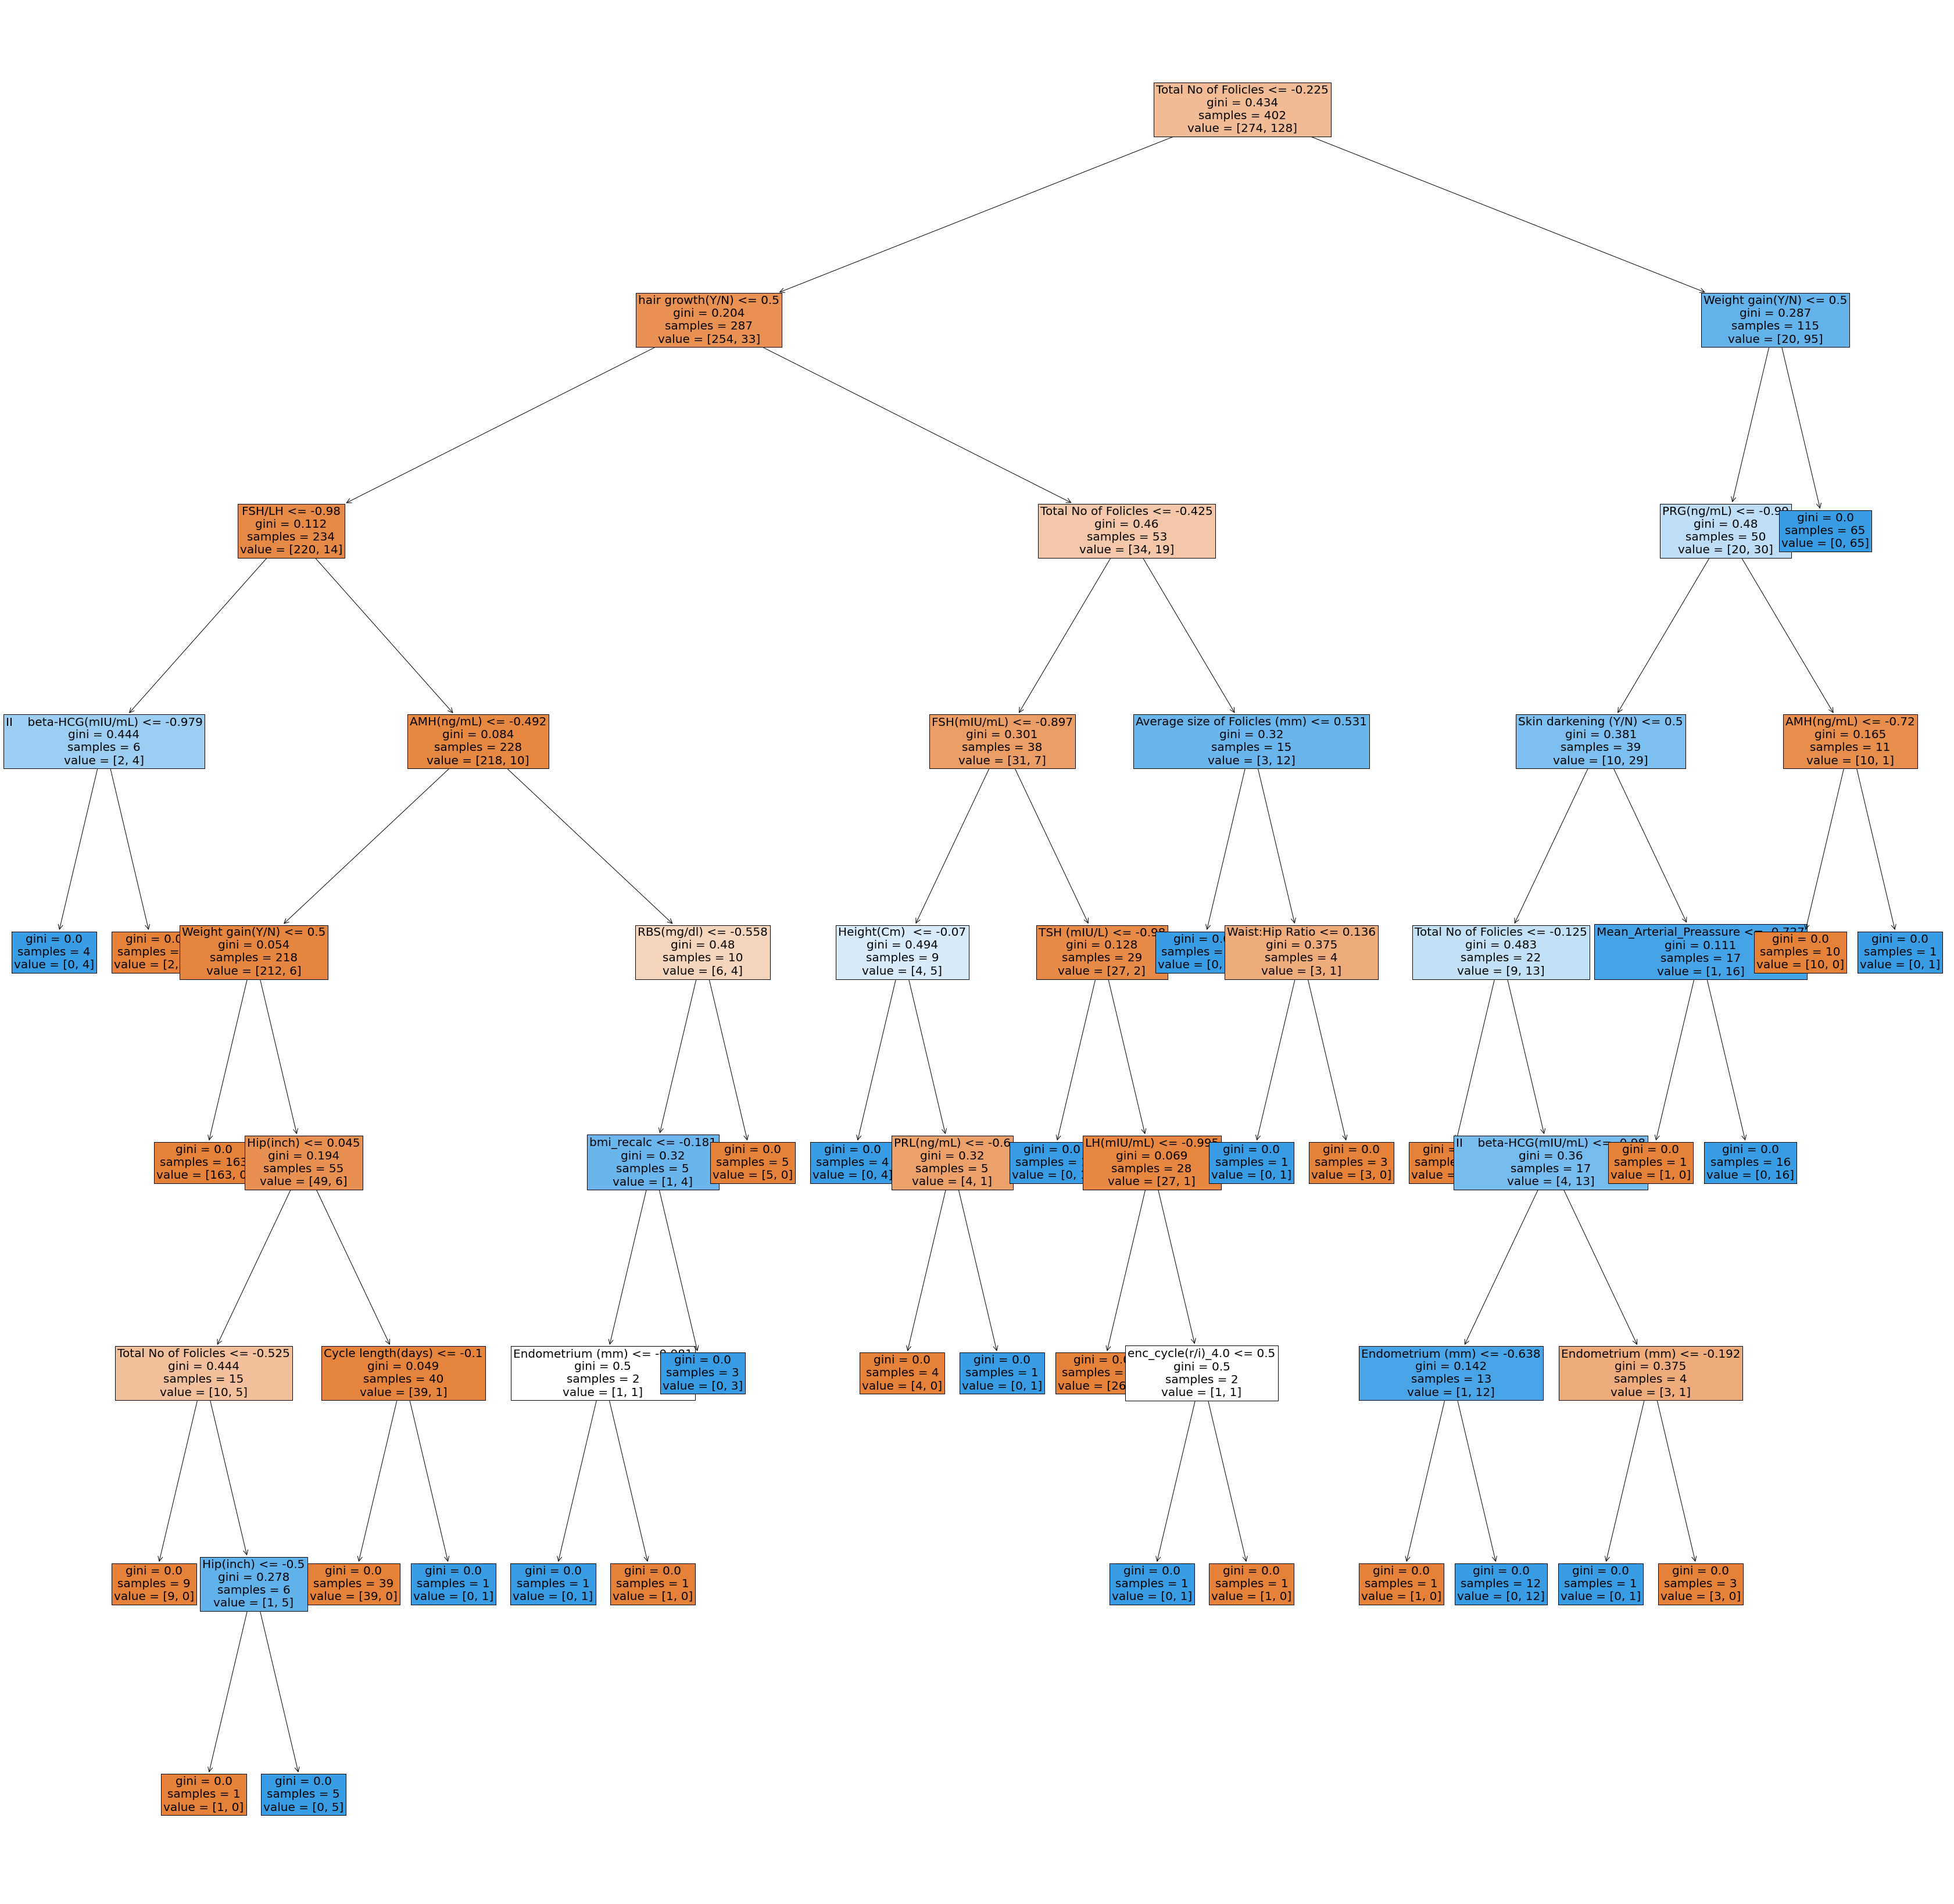

In [ ]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (60, 60))
tree.plot_tree(dtree_gini, feature_names=columns_names, filled=True, fontsize=20)
fig.show()

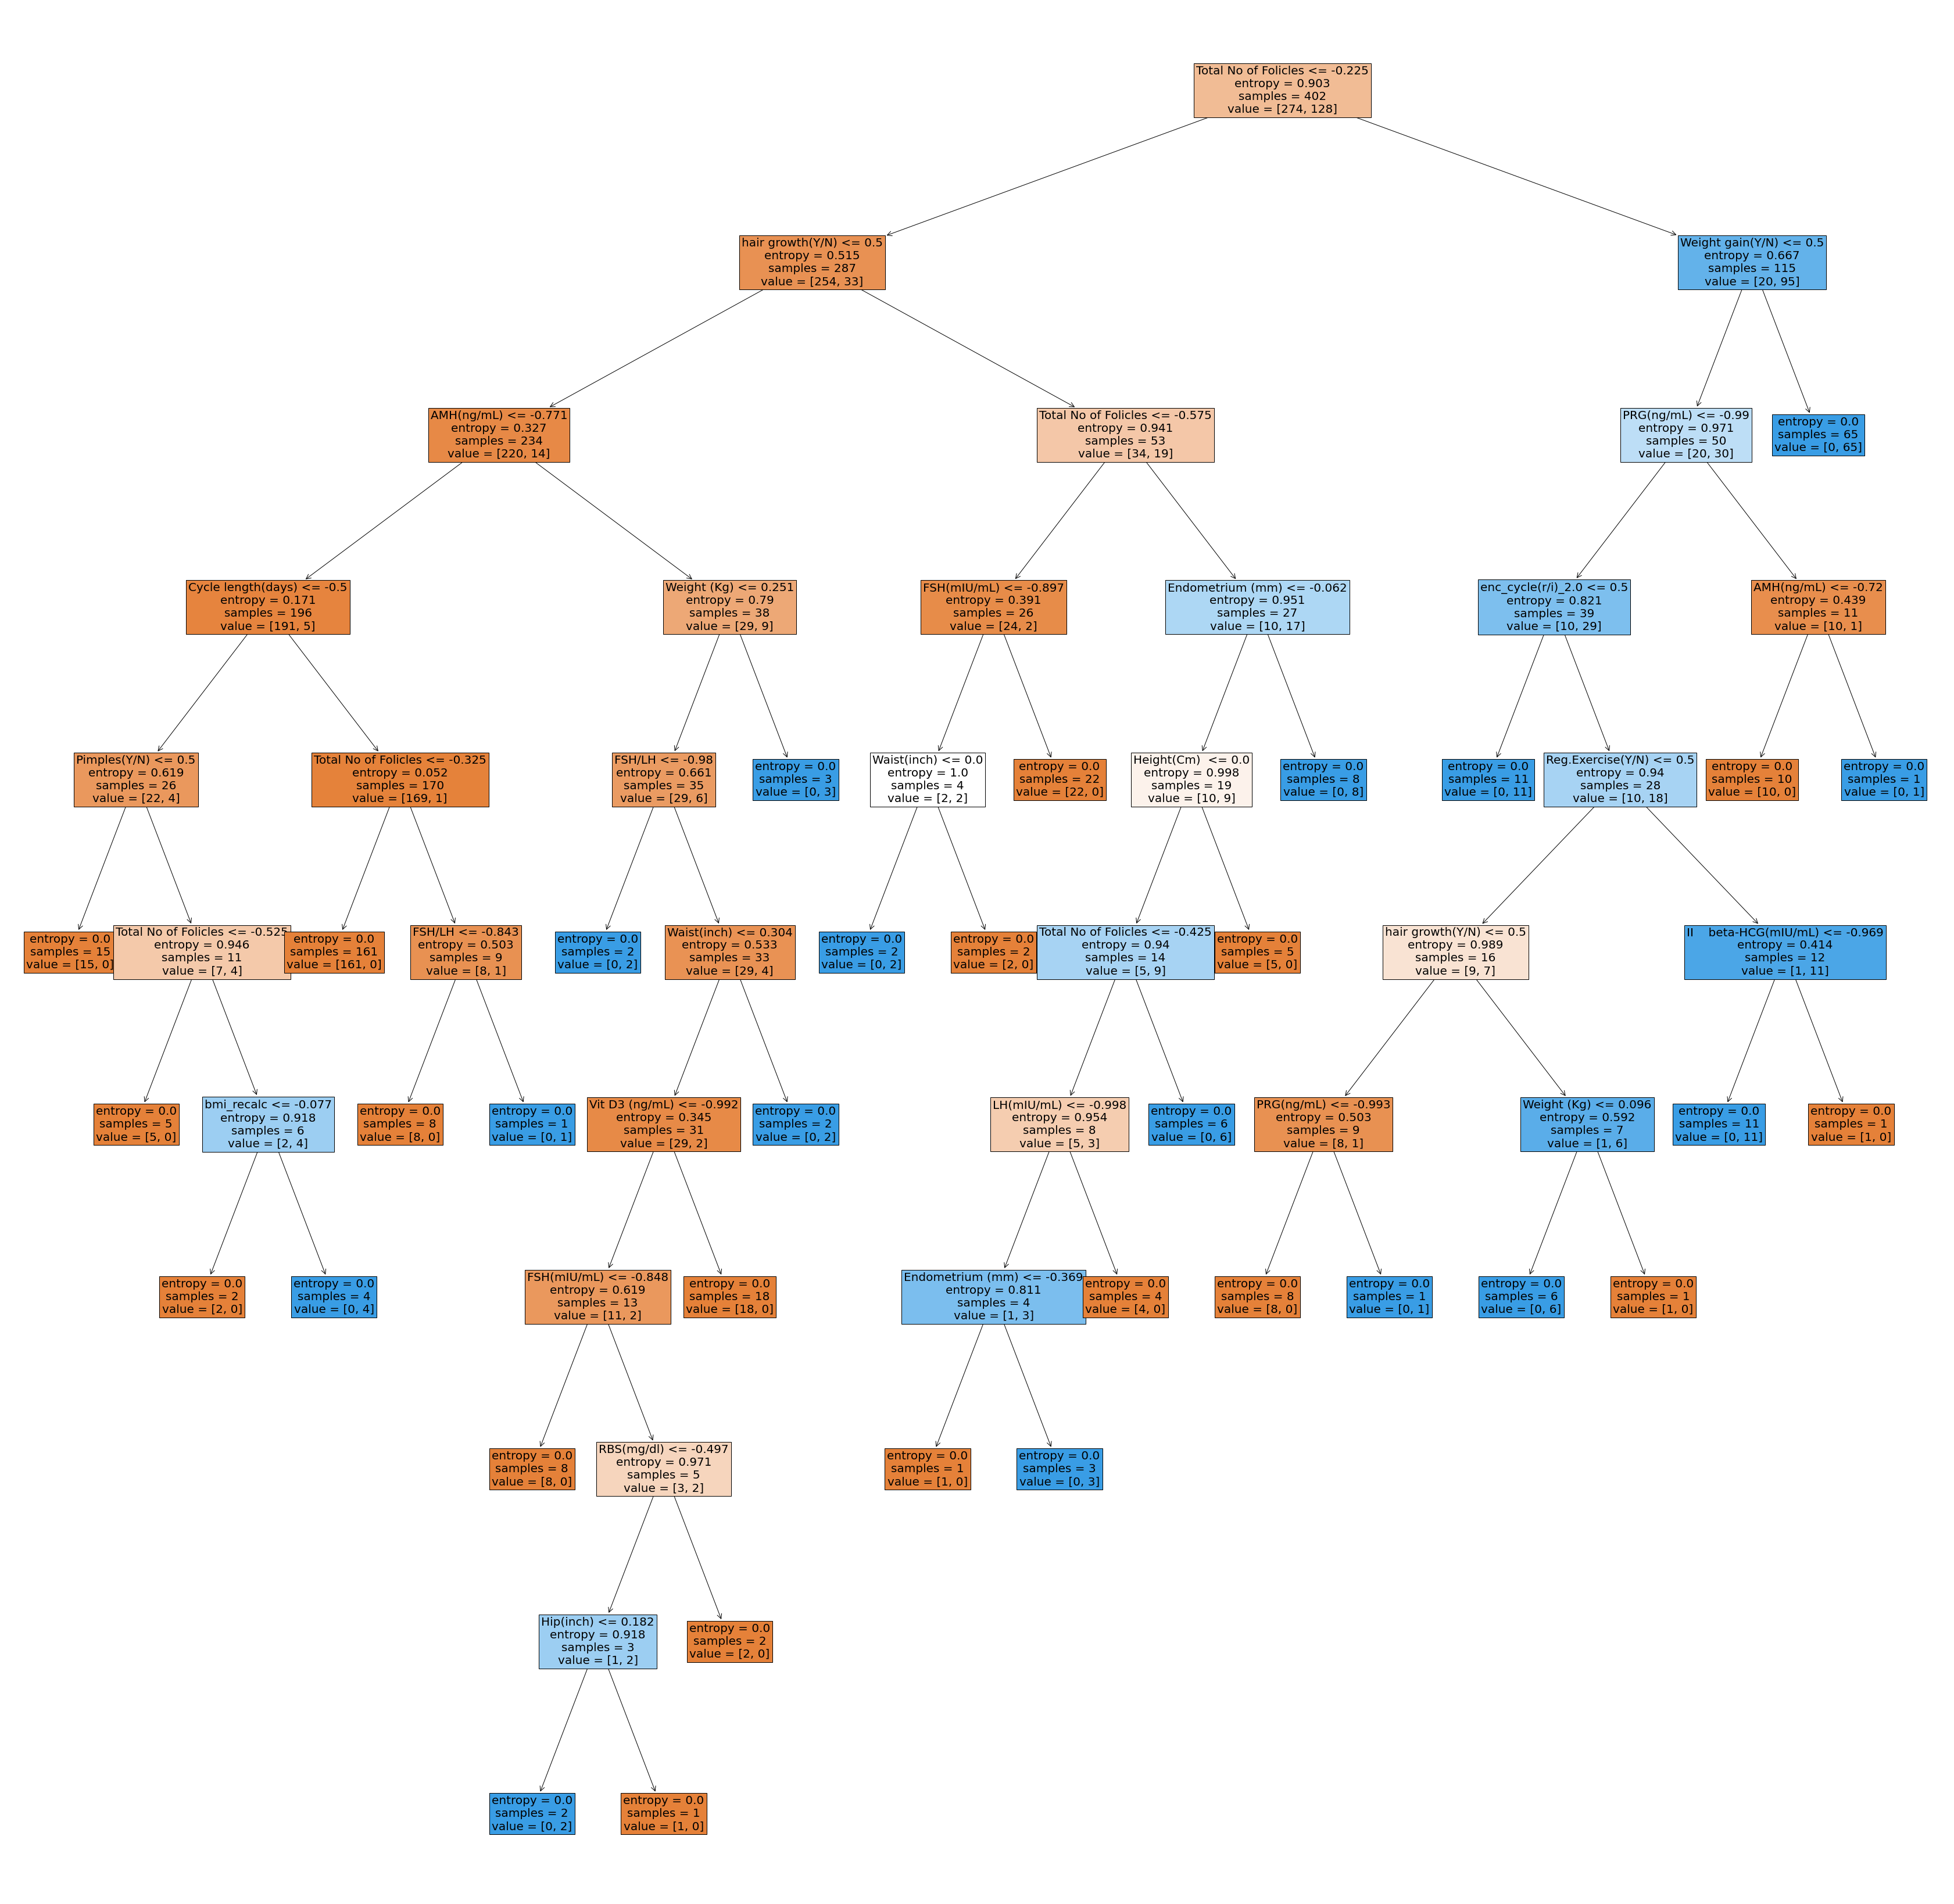

In [ ]:
fig, ax1 = plt.subplots(nrows = 1, ncols =1, figsize = (60, 60))
tree.plot_tree(dtree_ent, feature_names=columns_names, filled=True, fontsize=20)
fig.show()

**`min_samples_leaf`** vs **`min_sample_split`**

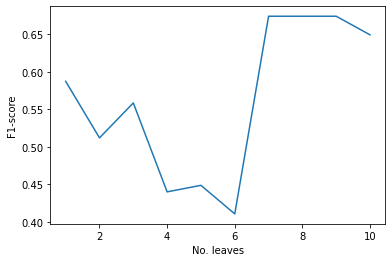

In [ ]:
# "gini" and "best" are already default values, still, I am including them for clarity
scores_leaves = []
leaves = range(1,11,1)
for i in leaves:
  j=i+1
  dtree_minleaf = DecisionTreeClassifier(criterion="gini", splitter="best", \
                                       min_samples_leaf=i, min_samples_split=j,\
                                        random_state=42)

  dtree_minleaf.fit(X_train_minmax, y_train)
  y_predicted = dtree_minleaf.predict(X_test_minmax)
  score = f1_score(y_test, y_predicted)
  scores_leaves.append(score)


fig, ax1 = plt.subplots()
ax1.plot(leaves, scores_leaves)
ax1.set_ylabel("F1-score")
ax1.set_xlabel("No. leaves")
plt.show()

0.6493506493506493

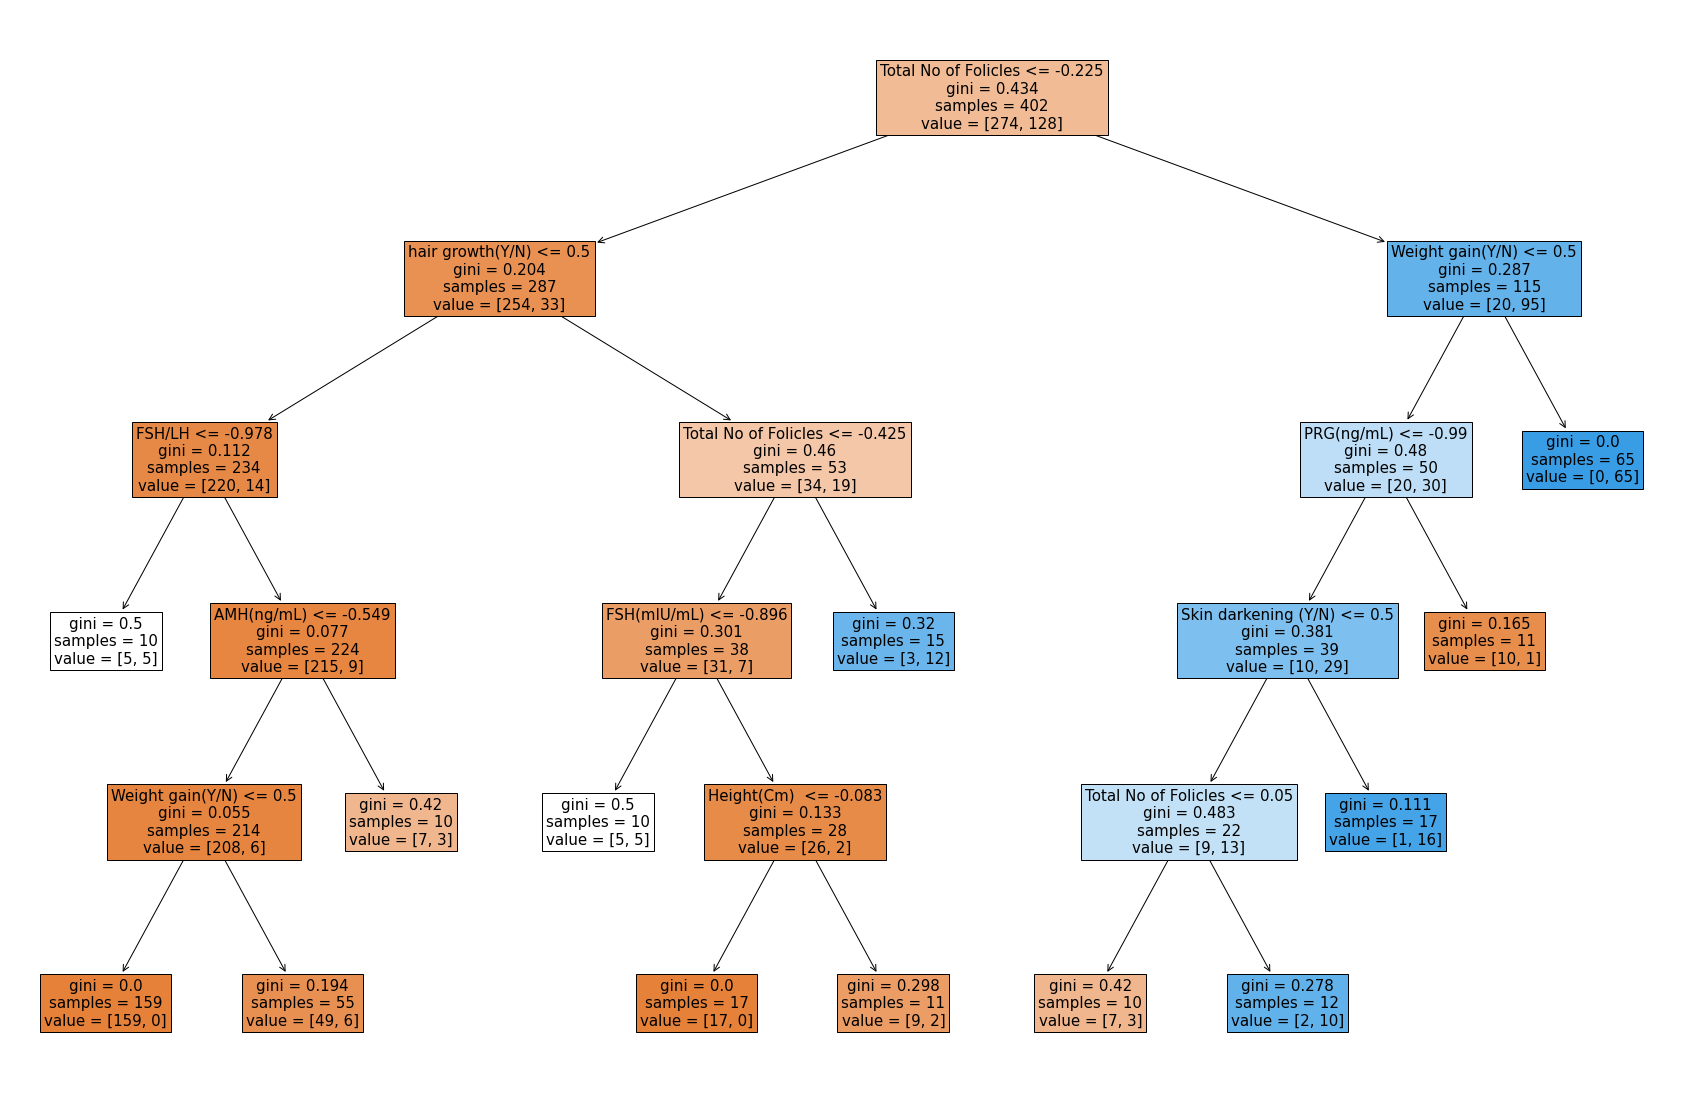

In [ ]:
dtree_minleaf = DecisionTreeClassifier(criterion="gini", splitter="best", \
                                       min_samples_leaf=10, min_samples_split=15, max_depth=5)

dtree_minleaf.fit(X_train_minmax, y_train)
y_predicted = dtree_minleaf.predict(X_test_minmax)
display(f1_score(y_test, y_predicted))


fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (30, 20))
tree.plot_tree(dtree_minleaf, feature_names=columns_names, filled=True, fontsize=15)
fig.show()

## **Feature importance with shaps**

In [ ]:
#Create object that can calculate shap values
sh_explainer = shap.TreeExplainer(dtree_minleaf.fit(X_train_minmax, y_train))

In [ ]:
#Calculate Shap values
shap_values = sh_explainer.shap_values(X_train_minmax)

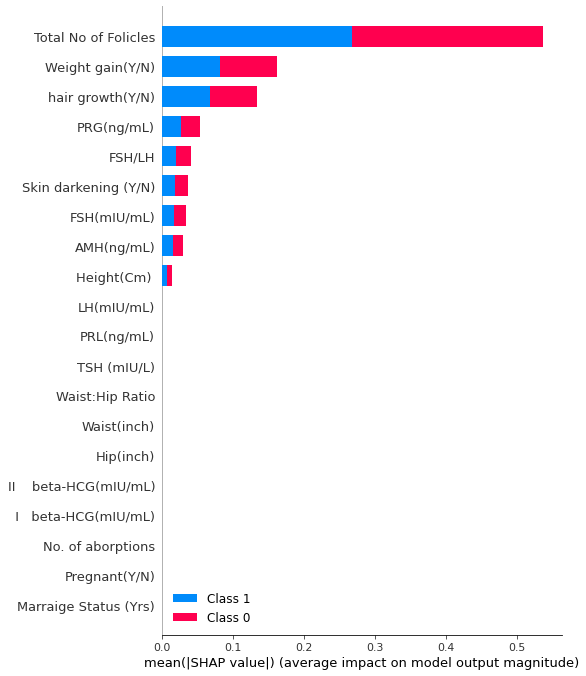

In [ ]:
#Summary Plot
shap.summary_plot(shap_values, X_train_minmax, feature_names=columns_names)

## **6. Hyper parm overview**
Discussion:
Before exploring which parameters improve or depreciate the model, it is important to note that the PCOS data set is imbalanced. 33% of women are diagnosed with PCOS, and 67% of women do not have this diagnosis. Overall the param split_random gives the best metrics, whereas the min_samp_leaf_2 gives the worst classification scores. A pie chart is included at the beginning of the PA4 notebook that shows the aforementioned imbalance.

Interestingly, recall is the only metric that outperforms with all parameters. It is clear that the deeper the decision tree model the better the performance of the recall. For instance, using the parameter max_depth_4 generates a recall of 0.83, and if this is set up to max_depth_4 the recall increases to 0.85.

It is important to note the area under the curve (AUC) and f1 score are two useful metrics when data is imbalanced. Thus, for this case, split_ramdom and split_1 parameters are crucial setting to improve the performance of the model, reaching values of 0.77 and 0.76 respectively when the auc is determined. In the case of f1 score, values arrive at 0.71 and 0.69 with split_ramdom and split_1 parameters respectively.

In the case of the `splitter` parameter, setting it as `random` improves the F1 score of this particular decision tree (for which the rest of the parameters are set as default). In either splitter cases, the first partition is (frequency-wise) mostly done in the “Total No. of Folicles” feature. However, setting splitter=random, allows a better partitioning of the subsequent nodes. For example, the case of “FSH/LH” and “AMH” with importances of ~0.026 and ~0.015, respectively. Both aforementioned features have similar importances (and << than the feature with the highest importance) but a “best” partition will choose “FSH/LH” over  “AMH “. However, a random partition allows exploring features with “similar” importances than can achieve better node splittings such as “AMH”.

Summarizing, for this particular model, the way of splitting the treebecomes a critical element in improving the model's performance. In the specific case of recall, increasing depth of the tree model significantly improves the recall score.



# **2. Final Decision Tree & Evaluation**

In [ ]:
# Get best DT ML model using best hyperparms
best_dtree = DecisionTreeClassifier(criterion="gini", splitter="random", \
                                       min_samples_leaf=6, min_samples_split=7, \
                                    max_depth=4, random_state=48 ) 


best_dtree.fit(X_train_minmax, y_train)
y_best_predicted = best_dtree.predict(X_test_minmax)
print(f"F1-score Best ML model: {f1_score(y_test, y_best_predicted)}")

F1-score Best ML model: 0.7209302325581396


### **1. Feature used in the first split**

Feature used in the first split is Total Number of Folicles

### **2. Number of leaves in the obtimal ML model**

In [ ]:
# number of leaves
bestdt_no_leaves = best_dtree.get_n_leaves
print(f"No. of leaves: {bestdt_no_leaves}")


No. of leaves: <bound method BaseDecisionTree.get_n_leaves of DecisionTreeClassifier(max_depth=4, min_samples_leaf=6, min_samples_split=7,
                       random_state=48, splitter='random')>


### **3. Confusion matrix**

Train data:
Total of examples in train data: 402



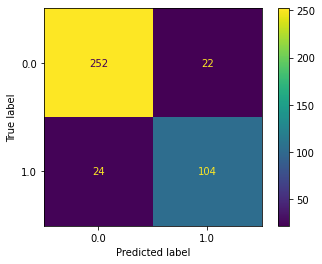

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
print("Train data:")
print(f"Total of examples in train data: {X_train_minmax.shape[0]}\n")
ConfusionMatrixDisplay.from_estimator(best_dtree, X_train_minmax, y_train)

Test data:
Total of examples in test data: 135



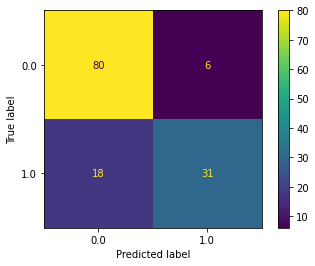

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
print("Test data:")
print(f"Total of examples in test data: {X_test_minmax.shape[0]}\n")
ConfusionMatrixDisplay.from_estimator(best_dtree, X_test_minmax, y_test)


### **4. Classification report**

In [ ]:
yhat_train = best_dtree.predict(X_train_minmax)

print("Training data:")
print(classification_report(y_train, yhat_train))

Training data:
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92       274
         1.0       0.83      0.81      0.82       128

    accuracy                           0.89       402
   macro avg       0.87      0.87      0.87       402
weighted avg       0.89      0.89      0.89       402



In [ ]:
yhat_test  = best_dtree.predict(X_test_minmax)
print("Test data:")
print(classification_report(y_test, yhat_test))

Test data:
              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87        86
         1.0       0.84      0.63      0.72        49

    accuracy                           0.82       135
   macro avg       0.83      0.78      0.80       135
weighted avg       0.82      0.82      0.82       135



### **Visualize the structure of our final ML model**
### **5. Plot tree**

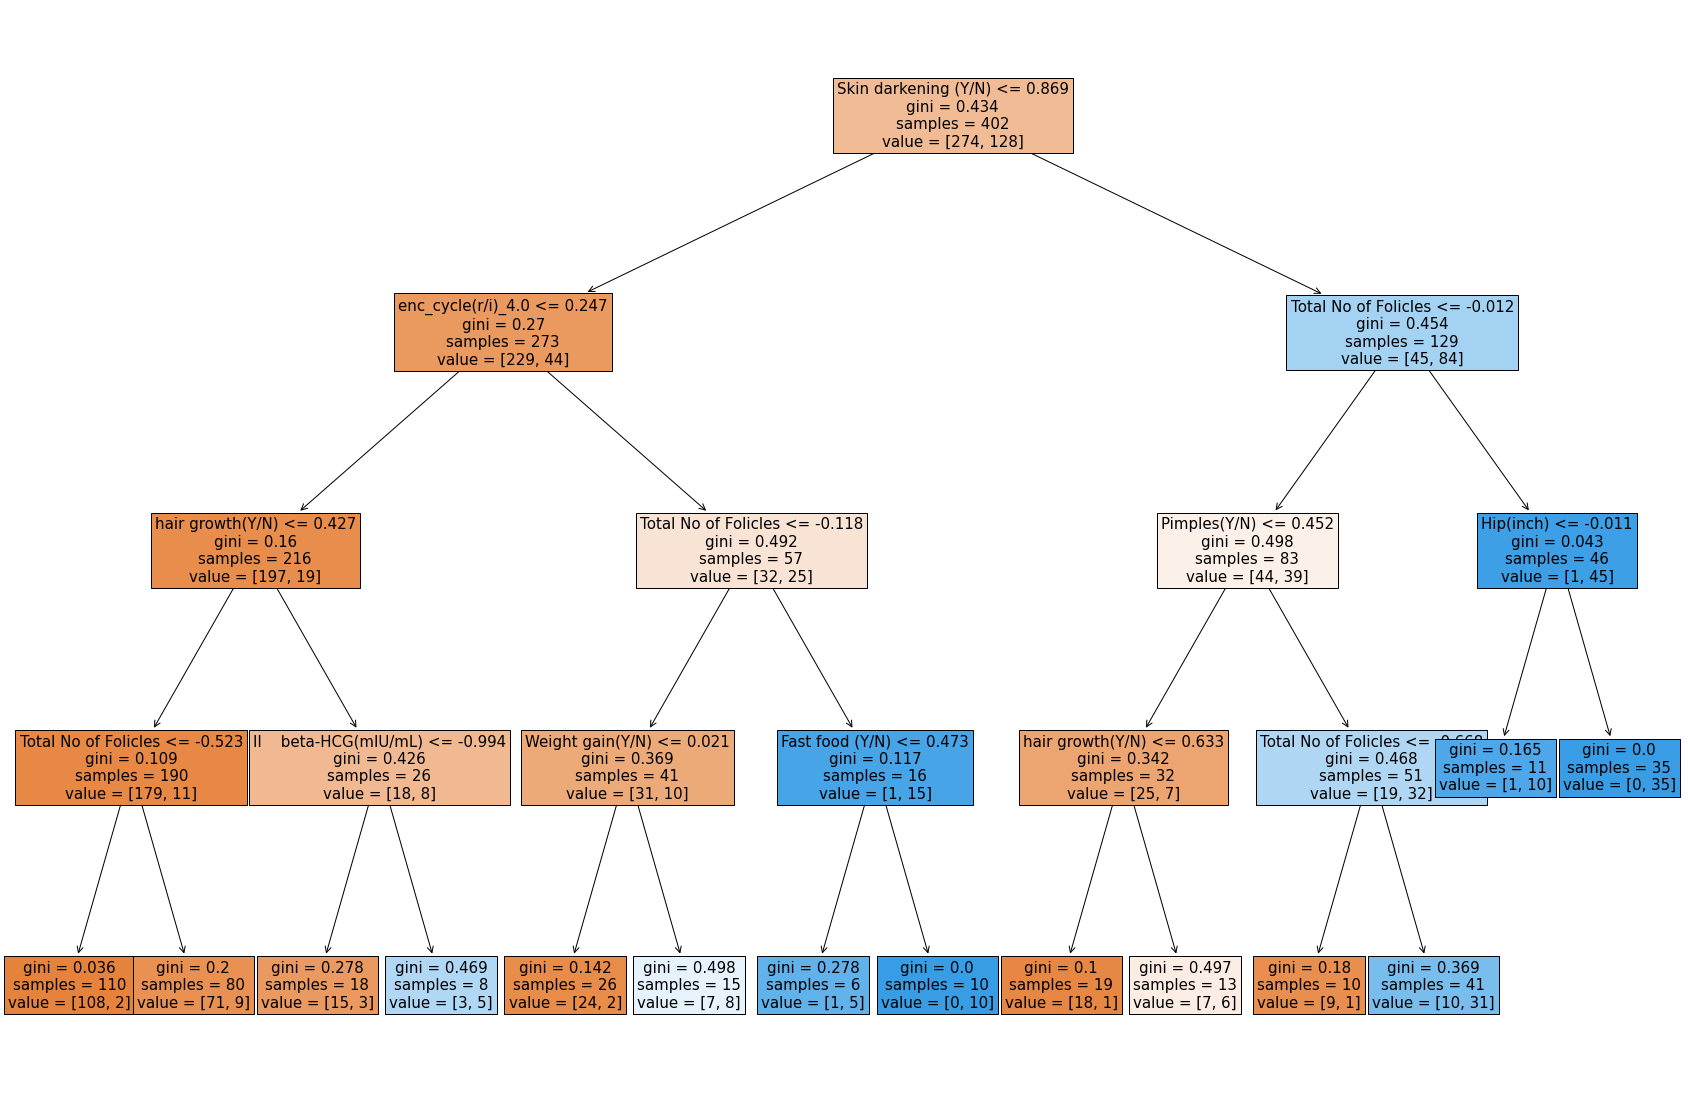

In [ ]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (30, 20))
tree.plot_tree(best_dtree, feature_names=columns_names, filled=True, fontsize=15)
fig.show()


### **6. Plot decision surface**

In [ ]:
import warnings
def plot_decision_boundary2D(clf, X: np.ndarray, y: np.ndarray, classes: list, colormap: np.ndarray,
                             step: float = 0.1, prob_dot_scale: int = 40, prob_dot_scale_power: int = 3,
                             true_dot_size: int = 50, pad: float = 1.0,
                             prob_values: list = [0.4, 0.6, 0.8, 1.0]) -> None:
    """
    Original work by @timothyvh on Twitter.
    Recreating an R ggplot decision boundary plotting in python using matplotlib.
    Note that this only works for 2D plotting. The goal of this function is to present a
    classifier's decision boundary in an easy to read, digestible way to ease
    communication and visualization of results.
    Arguments:
    clf - the classifier we want to visualize the decision boundary for. This should work for any kind of relevant model.
    X - our data we want to plot. Note that since this is a 2D array, X should be 2-dimensional.
    y - the target labels for the data we want to plot
    classes - the names of the classes you are trying to identify, should be same shape as colormap
    colormap - the colors you want to use to indicate your different classes, should be same shape as classes
    step - mesh stepsize
    prob_dot_scale - modifier to scale the probability dots
    prob_dot_scale_power - exponential used to increase/decrease size of prob dots
    true_dot_size - size of the true labels
    pad - how much to "pad" around the true labels
    prob_values - list of probabilities to map the meshgrid predictions to
    Returns:
    None - This function will simply output a graph of the decision boundary
    """
    # Handling X data dimension issues. If X doesn't have enough dimensions, throw error. Too many, use first two dimensions.
    X_dim = X.shape[1]
    if X_dim < 2:
        raise Exception("Error: Not enough dimensions in input data. Data must be at least 2-dimensional.")
    elif X_dim > 2:
        warnings.warn(f"Warning: input data was {X_dim} dimensional. Expected 2. Using first 2 dimensions provided.")
    # Change colormap to a numpy array if it isn't already (necessary to prevent scalar error)
    if not isinstance(colormap, np.ndarray):
        colormap = np.array(colormap)
    # create the x0, x1 feature. This is only a 2D plot after all.
    x0 = X[:,0]
    x1 = X[:,1]
    # create 1D arrays representing the range of probability data points
    x0_min, x0_max = np.round(x0.min())-pad, np.round(x0.max()+pad)
    x1_min, x1_max = np.round(x1.min())-pad, np.round(x1.max()+pad)
    x0_axis_range = np.arange(x0_min,x0_max, step)
    x1_axis_range = np.arange(x1_min,x1_max, step)
    # create meshgrid between the two axis ranges
    xx0, xx1 = np.meshgrid(x0_axis_range, x1_axis_range)
    # put the xx in the same dimensional format as the original X
    xx = np.reshape(np.stack((xx0.ravel(),xx1.ravel()),axis=1),(-1,2))
    yy_hat = clf.predict(xx) # prediction of all the little dots
    yy_prob = clf.predict_proba(xx) # probability of each dot being
                                    # the predicted color
    yy_size = np.max(yy_prob, axis=1)
    # make figure
    plt.style.use('seaborn-whitegrid') # set style because it looks nice
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6), dpi=150)
    
    # MSRT
    _yy_hat = yy_hat.astype(int)
    _y = y.astype(int)
    #MSRT
    # plot all the little dots
    ax.scatter(xx[:,0], xx[:,1], c=colormap[_yy_hat], alpha=0.4, s=prob_dot_scale*yy_size**prob_dot_scale_power, linewidths=0,)
    
    # plot the contours
    ax.contour(x0_axis_range, x1_axis_range,
               np.reshape(yy_hat,(xx0.shape[0],-1)),
               levels=2, linewidths=1,
               colors=[colormap[0],colormap[1]])
    # plot the original x values.
    ax.scatter(x0, x1, c=colormap[_y], s=true_dot_size, zorder=3, linewidths=0.7, edgecolor='k')
    # create legends - Not sure if these serve a purpose but I left them in just in case
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    ax.set_ylabel(r"$x_1$")
    ax.set_xlabel(r"$x_0$")
    # set the aspect ratio to 1, for looks
    ax.set_aspect(1)
    # create class legend
    legend_class = []
    for class_id, color in zip(classes, colormap):
        legend_class.append(Line2D([0], [0], marker='o', label=class_id,ls='None',
                                   markerfacecolor=color, markersize=np.sqrt(true_dot_size),
                                   markeredgecolor='k', markeredgewidth=0.7))
    # iterate over each of the probabilities to create prob legend
    legend_prob = []
    for prob in prob_values:
        legend_prob.append(Line2D([0], [0], marker='o', label=prob, ls='None', alpha=0.8,
                                  markerfacecolor='grey',
                                  markersize=np.sqrt(prob_dot_scale*prob**prob_dot_scale_power),
                                  markeredgecolor='k', markeredgewidth=0))
    legend1 = ax.legend(handles=legend_class, loc='center',
                        bbox_to_anchor=(1.05, 0.35),
                        frameon=False, title='class')
    legend2 = ax.legend(handles=legend_prob, loc='center',
                        bbox_to_anchor=(1.05, 0.65),
                        frameon=False, title='prob', )
    ax.add_artist(legend1) # add legend back after it disappears
    ax.set_yticks(np.arange(x1_min,x1_max, 1)) # I don't like the decimals
    ax.grid(False) # remove gridlines (inherited from 'seaborn-whitegrid' style)
    # only use integers for axis tick labels
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # remove first ticks from axis labels, for looks
    ax.set_xticks(ax.get_xticks()[1:-1])
    ax.set_yticks(np.arange(x1_min,x1_max, 1)[1:])
    plt.show()

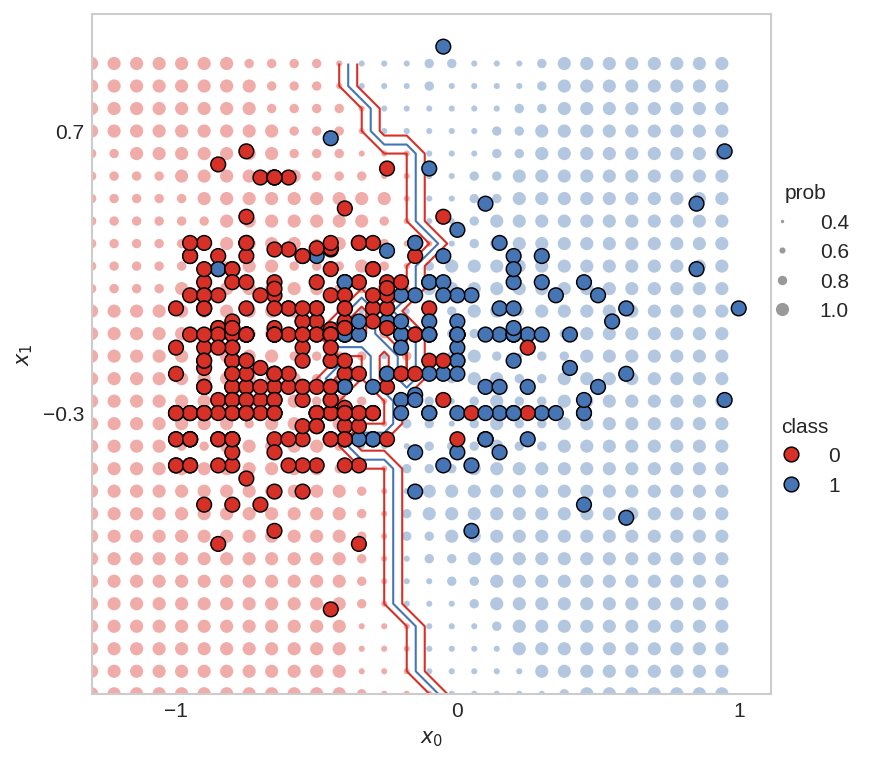

In [ ]:
H = 0.08 # mesh stepsize
PROB_DOT_SCALE = 40 # modifier to scale the probability dots
PROB_DOT_SCALE_POWER = 3 # exponential used to increase/decrease size of prob dots
TRUE_DOT_SIZE = 50 # size of the true labels
PAD = 0.3 # how much to "pad" around the true labels
# establish colors and colormap
redish = '#D73027'
blueish = '#4575B4'
colormap = np.array([redish, blueish])
#establish classes
classes = [0, 1]

# X_train_minmax2 = X_train_minmax[[" Age (yrs)", "Height(Cm) "]].copy()
# X_train_minmax2 = X_train_minmax[["Total No of Folicles", "FSH/LH"]].copy()
X_train_minmax2 = X_train_minmax[["Total No of Folicles", "Height(Cm) "]].copy()


X_train_minmax2 = X_train_minmax2.to_numpy()
y_train2 = y_train.copy()
y_train2 = y_train2.to_numpy()

# FOR K-NN neighbors
N_NEIGHBORS = 5 # KNN number of neighbors
clf = neighbors.KNeighborsClassifier(N_NEIGHBORS, weights='uniform')
clf.fit(X_train_minmax2, y_train2)

# # For DT
# clf = DecisionTreeClassifier(criterion="gini", splitter="random", \
#                                        min_samples_leaf=6, min_samples_split=7, \
#                                     max_depth=4, random_state=48 ) 


# clf.fit(X_train_minmax2, y_train2)


plot_decision_boundary2D(clf, X_train_minmax2, y_train2, classes, colormap,
                         step=H,
                         prob_dot_scale=PROB_DOT_SCALE,
                         prob_dot_scale_power=PROB_DOT_SCALE_POWER,
                         true_dot_size=TRUE_DOT_SIZE, pad=PAD)

### **Decision tree path**
### **7. Potential path of a new example and its result.**

According to the best decision tree model, the first node is the Skin darkening feature. A group of samples in this first node has a Gini of 0.43. Because this value is less 0.86 the path will continue with the enc_cycle feature. Then, the path will follow the Total No of Follicles because the Gini score of the enc_cycle feature is greater than 0.24. After that, this will go to the Fast food node. At the final step, the leaf will take a Gini value of 0. At this point all samples are classified with the group of women that do not have the PCOS diagnose.

# **3. ML Model Accuracy**

  - **K-NN**

|Index| Accuracy|	Precision| Recall|	AUC| 	f1_score|	K_values|weights |
|---|---|---|---|---|---|---|---|
|2| 0.859259| 0.969| 	0.633| 	0.811| 	0.765| 	11| 	uniform|
|3| 0.859259| 0.969| 	0.633| 	0.811| 	0.765| 	11| 	distance|
|4| 0.837037| 0.966|	0.571| 	0.780| 	0.718| 	15| 	uniform|
|5| 0.837037| 0.966| 	0.571| 	0.780| 	0.718| 	15| 	distance| 
|0| 0.829630| 0.861| 	0.633| 	0.787| 	0.729| 	5| 	uniform| 
|1| 0.829630| 0.861| 	0.633| 	0.787| 	0.729| 	5| 	distance|

  - **Decision Tree**

| Index | Accuracy | Precision | Recall |  AUC | f1_score |          Params |
|------:|---------:|----------:|-------:|------:|---------:|----------------:|
|   0   | 0.570    | 0.448     | 0.796  | 0.619 | 0.574    | crit_gini       |
|   1   | 0.667    | 0.529     | 0.755  | 0.686 | 0.622    | crit_entropy    |
|   2   | 0.430    | 0.360     | 0.735  | 0.495 | 0.483    | split_best      |
|   3   | 0.800    | 0.739     | 0.694  | 0.777 | 0.716    | split_random    |
|   4   | 0.785    | 0.717     | 0.673  | 0.761 | 0.695    | split_1         |
|   5   | 0.422    | 0.354     | 0.714  | 0.485 | 0.473    | split_2         |
|   6   | 0.444    | 0.367     | 0.735  | 0.507 | 0.490    | min_samp_leaf_1 |
|   7   | 0.422    | 0.344     | 0.653  | 0.472 | 0.451    | min_samp_leaf_2 |
|   8   | 0.430    | 0.373     | 0.837  | 0.517 | 0.516    | max_depth_4     |
|   9   | 0.437    | 0.378     | 0.857  | 0.527 | 0.525    | max_depth_8     |

Overall, the K-NN model outperforms the Decision Tree. Also, K-NN seems to be less sensitive to the selection of hyperparameters

# **4. Business evaluation**

What might be the motivation for a decision tree classifier?
A decision tree classifier gives the opportunity to explain how a model makes a decision for a regression or classification problem.. The designer can see how simple boolean questions or nodes of the tree address the classification problem and why a final decision is taken based on the design of the tree. In other words, a decision tree classifier provides a high level of interpretability. Which makes it a good option to explore the behavior of the data, including the contribution of the features towards the solution of the classification/regression problem.
                             
What is the “action” that should be taken given the results of this prediction?
Overall, in the best case scenario, the metrics for the performance of these models reach around 75%. A next step is to find ways to improve the performance of the final model. To do that, the final model could only contain the features that have a clear impact on the model. The idea is to reduce the complexity of the model and tackle overfitting. Based on the the results of features importance (within the context of the decision tree studied here), the following features have a high impact on the model’s prediction accuracy:
Total No of Follicles
Weight gain (Y/N)
Hair growth (Y/N)
PRL(ng/mL)
AMH(ng/mL)
Skin darkening (Y/N)
FSH(mIU/mL),
LH(mIU/mL)
The above observations are in agreement with the correlation matrix previously obtained and which is shown below. 

Alternatively, other algorithms could be used to build the PCOS classification model. It would be important to compare the performance of a model using the ‘Random Forest’ algorithm with the previously used algorithms (‘K-nearest neighborhood’, and ‘Decision Tree’).
                             
Who is the best immediate person(s) to make use of the results of your prediction?
A family physician could be the best immediate user of this classification model. A regular procedure in the public health system, patients are initially checked by a general practitioner (GP). Then, once the GP provides a diagnosis to patients, this can consider if it is necessary that a speciality manage a particular case. The issue in this workflow is that GPs do not have a high level of training to diagnose all diseases in comparison with specialists. In this scenario, GPs have high chances of missing or delaying the diagnosis of PCOS (Tay, et al., 2018),  resulting in undesirable outcomes for women. Thus, GPs could use this classification model to reduce their uncertainty for diagnosis and speed up the process to manage the disease with the gynecologist and the endocrinologist. Additionally, GPs could make decisions based on what are the features that play a critical role in the diagnosis of PCOS, according to standard statistics (correlation matrix) and ML model. For instance, with the understanding that the number of follicles has a high impact in the PCOS diagnosis, GPs could request ovarian follicles count by ultrasound as an initial screening of this disease. GPs could also use Follicles ultrasound ovary to track the progress of PCOS. Weight gain is another feature that has a high impact on the model. Therefore, GPs could start to manage this disease by starting a dietary and physical exercise plan with patients
                             
What is the potential payoff of this prediction for an organization? (e.g., costs or eciency).
Because this model could help to speed up the process of the diagnosis and posterior management of the disease, the health system could reduce the cost of the chronic outcomes of PCOS. For instante, in the United States the cost of PCOS during the initial diagnosis was $3.7 billion in 2020 (Riestenberg, et al., 2022). This economic burden is further increased when chronic conditions of PCOS are included, reaching $4.3 billion in one year (Riestenberg, et al., 2022). The efficiency of the management of PCOS could also be improved by implementing institutional standard guidelines and training to GPs about healthy diet and weight management.  
                             
Do your ML models’ results change your problem? If so, how and why? If not, please explain.
With these preliminary results, the problem business has not changed. Although the metrics have a modest performance classifying women with or without PCOS, this could be improved by either testing different algorithms or reducing the complexity of the model by making a curation of the features space.

                                
References:

Riestenberg, C., Jagasia, A., Markovic, D., Buyalos, R. P., & Azziz, R. (2022). Health Care-Related Economic Burden of Polycystic Ovary Syndrome in the United States: Pregnancy-Related and Long-Term Health Consequences. The Journal of clinical endocrinology and metabolism, 107(2), 575–585. https://doi.org/10.1210/clinem/dgab613

Tay, C. T., Moran, L. J., Wijeyaratne, C. N., Redman, L. M., Norman, R. J., Teede, H. J., & Joham, A. E. (2018). Integrated Model of Care for Polycystic Ovary Syndrome. Seminars in reproductive medicine, 36(1), 86–94. https://doi.org/10.1055/s-0038-1667310